In [1]:
# !pip install snowflake --user
# !pip install snowflake-connector-python --user
# # !pip install matplotlib
# # !pip install seaborn

# Data

In [1]:
import os
import sys
import logging
import boto3
import itertools as it
import io
from utils import *
import snowflake.connector

In [2]:
from matplotlib.pyplot import figure

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import GroupKFold

In [5]:
import datetime

In [6]:
from datetime import timedelta

In [7]:
import scipy.stats as st

In [8]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

In [9]:
class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

In [10]:
def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

In [11]:
# run_query('''
# copy into max_dev.workspace.pct_actives_metric_values
#     from(
#         select
#               $1
#             , $2
#             , $3
#             , $4
#         from @HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV/pct_actives_prediction/pct_actives_metric_values.csv
#         )
#     file_format = (type = csv null_if=(''))
#     on_error = 'CONTINUE'
# ''')

In [12]:
logger = logging.getLogger()
logger.info(f'Loading inputs')
data_list =[]

s3 = boto3.resource('s3')
bucket = s3.Bucket('hbo-ingest-datascience-content-dev')

In [13]:
for obj in bucket.objects.filter(Prefix='input_percent_view'):
    key = obj.key
    logger.info('Loading csv file {}'.format(key))
    body = obj.get()['Body']
    var_name = key.split('.')[0].split('/')[1]
    print('Reading {0} features'.format(var_name))
    exec("{0}=pd.read_csv(body, na_values = [r'\\\\N'])".format(var_name))
    exec("{0}.columns = {0}.columns.str.lower()".format(var_name))
    
    # exclude the full null columns
    exec("{0} = {0}.loc[:,{0}.isnull().sum()!={0}.shape[0]]".format(var_name))

    # exclude the old Mortal Kombat movie because the trailer percent view 
    # matching matches the trailer of the new movie to the old movie
    # exclude Tom & Jerry due to unresolvable data issue
    exec("{0} = {0}.loc[{0}['match_id_platform'].\
        isin(['1-GYGQBcwsaCIW2XgEAAAAL', '0-GYGQBcwsaCIW2XgEAAAAL', '1-GYEb9QwLgFF9_ZwEAAAA7', '0-GYEb9QwLgFF9_ZwEAAAA7'])==False,:]\
        .reset_index(drop = True)".format(var_name))
    
    # append the feature df
    exec("data_list.append({0})".format(var_name))

Reading funnel_metric_feature features
Reading media_cost_postlaunch_feature features
Reading media_cost_prelaunch_feature features
Reading metadata_feature features
Reading prelaunch_trailer_feature features
Reading prelaunch_trailer_feature_before28 features
Reading sub_total_feature features
Reading trailer_feature features
Reading vtp_feature features
Reading wiki_view_feature_before28 features
Reading wiki_view_post_feature features
Reading wiki_view_pre_feature features


In [14]:
for obj in bucket.objects.filter(Prefix='pct_actives_prediction/pct_actives_metric_values'):
    key = obj.key
    logger.info('Loading csv file {}'.format(key))
    body = obj.get()['Body']
    var_name = key.split('.')[0].split('/')[1]
    print('Reading {0} features'.format(var_name))
    exec("{0}=pd.read_csv(body, na_values = [r'\\\\N'])".format(var_name))
    exec("{0}.columns = {0}.columns.str.lower()".format(var_name))
    
    # exclude the full null columns
    exec("{0} = {0}.loc[:,{0}.isnull().sum()!={0}.shape[0]]".format(var_name))

    # exclude the old Mortal Kombat movie because the trailer percent view 
    # matching matches the trailer of the new movie to the old movie
    # exclude Tom & Jerry due to unresolvable data issue
    exec("{0} = {0}.loc[{0}['match_id'].\
        isin(['1-GYGQBcwsaCIW2XgEAAAAL', '0-GYGQBcwsaCIW2XgEAAAAL', '1-GYEb9QwLgFF9_ZwEAAAA7', '0-GYEb9QwLgFF9_ZwEAAAA7'])==False,:]\
        .reset_index(drop = True)".format(var_name))
    
    # append the feature df
    exec("data_list.append({0})".format(var_name))

Reading pct_actives_metric_values features


# Metadata

In [15]:
metadata_feature = data_list[3]

In [16]:
active_data = data_list[-1][['match_id', 'days_on_hbo_max', 'pct_actives']]
active_data = active_data.merge(metadata_feature[['match_id', 'match_id_platform']], on = 'match_id')
active_data.drop(['match_id'], axis = 1, inplace = True)

In [17]:
active_data['pct_actives_values'] = active_data.groupby(['match_id_platform', 'days_on_hbo_max'])['pct_actives'].transform('mean')
active_data = active_data[['match_id_platform', 'days_on_hbo_max', 'pct_actives_values']]
active_data = active_data[(active_data['match_id_platform'].notnull())
                         &(active_data['days_on_hbo_max'].notnull())]
active_data.drop_duplicates(inplace = True)

In [18]:
active_data = active_data.pivot(index='match_id_platform', columns='days_on_hbo_max', values=['pct_actives_values']).reset_index()
columns = ['day00' + str(i) + '_percent_actives' for i in range(1, 10) ]
columns = columns + ['day0' + str(i) + '_percent_actives' for i in range(10, 29)]
active_data.columns = ['match_id_platform'] + columns

In [19]:
data_list.pop(-1)
data_list.append(active_data)

In [20]:
popcorn_titles = run_query('''
SELECT * FROM MAX_PROD.CATALOG.POPCORN_TITLES
''')

In [21]:
## Total Active Base
daily_total_views = run_query('''
select *, datediff(day, start_date, end_date)+1 as days_after_launch
from max_dev.workspace.actives_base_first_view
where days_after_launch<= 28
order by start_date
''')

In [22]:
# Daily Actives by title
title_actives = run_query('''
with max_release_date_base as (

        select
          distinct
          rad.title_id,
          case
            when rad.season_number is null
                then title_name
            else concat(rad.series_title_long,' S',rad.season_number)
          end as title,
          'Seasons and Movies' as title_level,
          first_value(raod.first_offered_date) over (partition by title order by raod.first_offered_date asc) as first_release_date,
          case
            when aod.offering_start_date <='2020-05-27 07:00:00' THEN '2020-05-27 07:00:00'
            else aod.offering_start_date
          end as offering_start_date,
          aod.offering_end_date
          , case when content_category = 'series'
            then ifnull(season_number, 1)
            else season_number
                end as season_number_adj
        , coalesce(concat(rad.series_id, '-', season_number_adj), rad.viewable_id) as match_id
        from
          max_prod.catalog.reporting_asset_dim rad
        join max_prod.catalog.asset_offering_dim aod
            on rad.viewable_id = aod.viewable_id
                and aod.offering_end_date>='2020-05-27 07:00:00'
                AND aod.brand = 'HBO MAX'
        join max_prod.catalog.reporting_asset_offering_dim raod
          on aod.viewable_id = raod.viewable_id
            AND aod.channel = raod.channel
            AND aod.brand = raod.brand
            AND raod.territory = aod.territory -- leave as HBO MAX domestic because no MUS?
        where
          raod.first_offered_date is not null
          and rad.asset_type = 'FEATURE'
          and offering_start_date<=sysdate()
          and aod.territory='HBO MAX DOMESTIC'
      ),
      second as (
        SELECT
           s1.title_id,
           s1.match_id,
           s1.title,
           s1.title_level,
           s1.first_release_date,
           s1.offering_start_date,
           MIN(t1.offering_end_date) AS offering_end_date
        FROM max_release_date_base s1
          INNER JOIN max_release_date_base t1 ON s1.offering_start_date <= t1.offering_end_date and s1.title_id=t1.title_id and s1.title=t1.title and s1.title_level=t1.title_level
            AND NOT EXISTS(SELECT * FROM max_release_date_base t2
                           WHERE t1.offering_end_date >= t2.offering_start_date AND t1.offering_end_date < t2.offering_end_date
                            and t1.title_id=t2.title_id and t1.title=t2.title
                          )
        WHERE NOT EXISTS(SELECT * FROM max_release_date_base s2
                           WHERE s1.offering_start_date > s2.offering_start_date AND s1.offering_start_date <= s2.offering_end_date
                            and s1.title_id=s2.title_id and s1.title=s2.title
                          )
        GROUP BY 1,2,3,4,5, 6
        order by 1,2,3,4,5, 6
      ),
      third as
        (SELECT
        title_id,
        title,
        title_level,
        match_id,
        max(offering_end_date) as end_date
        from second
        group by 1,2,3,4),
      fourth as
        (SELECT
         title_id,
        title,
        title_level,
        match_id,
        case when end_date>=sysdate() then FALSE
        else TRUE end as is_inactive
        from third),
       fifth as
         (SELECT
         title,
         title_id,
         title_level,
         max(days_on_hbo_max) as total_days
        from content_intelligence.new_title_release_days_on_platform
        group by 1,2,3)

     SELECT c.match_id, a.title, a.first_release_date, a.DAILY_VIEWING_SUBS, a.CUMULATIVE_VIEWING_SUBS, 
             a.days_on_hbo_max, a.title_id
       FROM content_intelligence.new_title_release_days_on_platform a
        inner join fifth b on initcap(a.title)=initcap(b.title) and a.title_id=b.title_id and a.title_level=b.title_level
        inner join fourth c on initcap(a.title)=initcap(c.title) and a.title_id=c.title_id and a.title_level=c.title_level
      where (days_on_hbo_max between 1 and 28)
''')

In [23]:
title_actives.drop_duplicates(inplace = True)

In [24]:
title_actives['available_date'] = title_actives['first_release_date'].astype(str).str[0:10:1]

In [25]:
pct_actives = pd.merge(title_actives[['match_id', 'title', 'title_id', 'days_on_hbo_max', 'available_date', 'cumulative_viewing_subs']], 
                      daily_total_views[['start_date', 'end_date', 'cumulative_viewing_subs_denom', 'days_after_launch']],
                      left_on = ['available_date', 'days_on_hbo_max'], right_on = ['start_date', 'days_after_launch'],
                      how = 'left')

In [26]:
pct_actives['pct_actives'] = pct_actives['cumulative_viewing_subs']/pct_actives['cumulative_viewing_subs_denom']*100

In [27]:
metadata_feature = metadata_feature.groupby(['match_id']).first().reset_index()

In [28]:
pct_actives['match_id'] = pct_actives['match_id'].astype(str)
metadata_feature['match_id'] = metadata_feature['match_id'].astype(str)

In [29]:
pct_actives=pd.merge(pct_actives,
                      metadata_feature.rename(columns = {'title_name':'id'}), 
                      on = ['match_id'],how = 'left')

In [30]:
recent_originals = pct_actives[(pct_actives['program_type'] == 'original')
                         &(pct_actives['prod_release_year'] >= 2020)
                         &(pct_actives['platform_name'] == 1)
                         ].copy()

popcorn_titles = pd.merge(pct_actives,  popcorn_titles[['viewable_id']],
                         left_on = ['match_id'], right_on = ['viewable_id']).copy()

In [31]:
recent_originals['originals_after_launch'] = 1
popcorn_titles['popcorn_titles'] = 1

In [32]:
recent_originals.drop_duplicates(inplace = True)

In [33]:
popcorn_titles.drop_duplicates(inplace = True)

In [34]:
pct_actives = pd.merge(pct_actives, recent_originals[['match_id', 'originals_after_launch', 'days_on_hbo_max', 'available_date']],
                        on = ['match_id', 'days_on_hbo_max', 'available_date'], how = 'left')


In [35]:
pct_actives = pd.merge(pct_actives, popcorn_titles[['match_id', 'popcorn_titles', 'days_on_hbo_max', 'available_date']],
                        on = ['match_id', 'available_date', 'days_on_hbo_max'], how = 'left')

In [36]:
pct_actives.loc[pct_actives['originals_after_launch'] == 1, 'originals_type'] = 'originals_after_launch'
pct_actives.loc[pct_actives['popcorn_titles'] == 1, 'originals_type'] = 'popcorn_titles'
pct_actives['originals_type'] = pct_actives['originals_type'].fillna(pct_actives['program_type'])
pct_actives = pct_actives.drop(['originals_after_launch', 'popcorn_titles'], axis = 1)

In [37]:
pct_actives['real_date'] = (pd.to_datetime(pct_actives['available_date']) +
                            pd.to_timedelta(pct_actives['days_on_hbo_max'], unit='D'))

## write to S3

In [38]:
# def to_s3(filename, output_bucket, content):
#     client = boto3.client('s3')
#     client.put_object(Bucket=output_bucket, Key=filename, Body=content)

In [39]:
# input_bucket = 'hbo-ingest-datascience-content-dev'

In [40]:
# csv_buffer = io.StringIO()
# pct_actives.to_csv(csv_buffer, index = False)
# content = csv_buffer.getvalue()

# filename = 'pct_actives_prediction/pct_actives.csv'

# to_s3(filename, input_bucket, content)

# MODEL

In [41]:
META_COLUMNS = ['match_id',
                'title',
                'title_id',
                'available_date',
                'originals_type',
                'content_category',
                'real_date',
                'prediction_start_day',
                ]
TRACKING_COLUMN = {'pct_actives': 'pct_actives',
                 'total_actives': 'total_viewing_accounts',
                 'title_actives': 'title_viewing_accounts',
                 }

In [42]:
class DecayModel:
    def __init__(self, kpi):
        self.tracking_col = TRACKING_COLUMN[kpi]
        self.multiplier_df = None
        
    def fit(self, train_df):
        pct_actives = train_df
        pct_actives_from = pct_actives[['originals_type', 'content_category',
                                    'match_id','prediction_start_day', self.tracking_col]]
        pct_actives_from.rename(columns={self.tracking_col: self.tracking_col + '_from'}, inplace=True)


        pct_actives_to = pct_actives[['originals_type', 'content_category',
                                        'match_id','prediction_start_day', self.tracking_col]]
        pct_actives_to.rename(columns={self.tracking_col: self.tracking_col + '_to',
                                         'prediction_start_day': 'days_after_launch'}, inplace=True)


        multipliers = pd.merge(pct_actives_from, pct_actives_to,
                           on=['originals_type', 'content_category',
                               'match_id'])
        multipliers['multiplier'] = multipliers[self.tracking_col + '_to'] / multipliers[self.tracking_col+ '_from']
        multiplier_df = multipliers.groupby(['originals_type', 'content_category',
                                             'prediction_start_day', 'days_after_launch'],
                                            as_index=False).agg({'multiplier': 'median'})
        self.multiplier_df = multiplier_df
        
    def predict(self, pred_df):
                
        postlaunch_df = pred_df[META_COLUMNS + [self.tracking_col]]
        
        assert self.tracking_col in postlaunch_df.columns


        postlaunch_df = pd.merge(postlaunch_df, self.multiplier_df,
                                 on=['originals_type', 'content_category', 'prediction_start_day'],
                                 how='left')
        
        postlaunch_prediction = np.where(postlaunch_df['prediction_start_day'] > postlaunch_df['days_after_launch'],
                                         np.nan,
                                         postlaunch_df[self.tracking_col] * postlaunch_df['multiplier'])

        postlaunch_df['prediction'] = postlaunch_prediction
        
        
        postlaunch_df = postlaunch_df[META_COLUMNS + ['days_after_launch', 'prediction']]
        
        return postlaunch_df

# Cross Validation

In [47]:
data_train_all_28 = pct_actives[(pct_actives['days_on_hbo_max'] == 28) & (pct_actives['pct_actives'] > 1)]

In [48]:
kpi = 'pct_actives'

data_train_all = pct_actives[pct_actives['match_id'].isin(data_train_all_28.match_id)]

data_train_all.rename(columns={"days_after_launch": "prediction_start_day"}, inplace=True)
data_train_all['real_date'] = data_train_all['real_date'].map(str).map(lambda x: x[:10])
data_train_all['available_date'] = data_train_all['available_date'].map(str).map(lambda x: x[:10])

# logger.info("nrow(features): " + str(len(data_train_all.index)))
print("nrow(features): " + str(len(data_train_all.index)))

validation_set = pd.DataFrame()

num_folds = len(data_train_all['match_id'].unique())
group_kfold = GroupKFold(n_splits=num_folds)
print (group_kfold)

# Train

nrow(features): 18366
GroupKFold(n_splits=652)


In [49]:
for train_index, test_index in group_kfold.split(data_train_all, groups=data_train_all['match_id'].values):


    train_df, test_df = data_train_all.iloc[train_index], data_train_all.iloc[test_index]


    avail_date = test_df['available_date'].values[0]
    train_df = train_df[(train_df['available_date'] <= avail_date)]

    print("Validation Title: " + str(test_df['id'].values[0]))

    # fit_predict decay model
    decay_model = DecayModel(kpi=kpi)
    decay_model.fit(train_df)
    pred = decay_model.predict(test_df)
    validation_set = pd.concat((validation_set, pred))

validation_set = validation_set[validation_set['days_after_launch'].notnull()]
validation_set.reset_index(drop=True, inplace=True)
# post-process
validation_set.rename(columns={'real_date': 'prediction_start_date'}, inplace=True)
validation_set['real_date'] = pd.to_datetime(validation_set['available_date']
                                            ).add(
    validation_set['days_after_launch'].map(lambda x: datetime.timedelta(x))
    ).map(str).map(lambda x: x[:10])

validation_set = pd.merge(validation_set,
                          data_train_all[
                              ['match_id', 'real_date', 'season_number_adj'] + [TRACKING_COLUMN[kpi]]],
                          on=['match_id', 'real_date'],
                          how='left')

validation_set.rename(columns={TRACKING_COLUMN[kpi]: 'actuals'}, inplace=True)

validation_set = validation_set[['match_id',
                                 'title',
                                 'title_id',
                                 'available_date',
                                 'originals_type',
                                 'content_category',
                                 'prediction_start_date',
                                 'real_date',
                                 'prediction_start_day',
                                 'days_after_launch',
                                 'actuals',
                                 'prediction']]

Validation Title: Cry Macho
Validation Title: Scenes From a Marriage S1
Validation Title: A Fistful of Dollars
Validation Title: The Good, the Bad and the Ugly
Validation Title: In the Heights
Validation Title: South Park S11
Validation Title: The Fresh Prince of Bel-Air S3
Validation Title: The Big Bang Theory S1
Validation Title: Pretty Little Liars S1
Validation Title: The Change-Up
Validation Title: The Hills Have Eyes
Validation Title: Happy Gilmore
Validation Title: Billy Madison
Validation Title: The Fresh Prince of Bel-Air S4
Validation Title: The Fresh Prince of Bel-Air S1
Validation Title: The Fresh Prince of Bel-Air S2
Validation Title: The Big Bang Theory S11
Validation Title: Robot Chicken S1
Validation Title: Godzilla: King of the Monsters
Validation Title: John Wick: Chapter 3 - Parabellum
Validation Title: Contagion
Validation Title: Aqua Teen Hunger Force S1
Validation Title: Bridesmaids
Validation Title: The Big Bang Theory S10
Validation Title: The Big Bang Theory S3

In [ ]:
validation_set.to_csv('validation_set_post_launch.csv')

# Scoring

In [33]:
pct_actives = pct_actives[(pct_actives['originals_type'] == 'originals_after_launch')
               |(pct_actives['originals_type'] == 'popcorn_titles')]
pct_actives['max_days'] = pct_actives.groupby(['match_id'])['days_after_launch'].transform(max)
pct_actives.rename(columns={"days_after_launch": "prediction_start_day"}, inplace=True)
pct_actives['real_date'] = pct_actives['real_date'].map(str).map(lambda x: x[:10])
pct_actives['available_date'] = pct_actives['available_date'].map(str).map(lambda x: x[:10])

train_df = pct_actives[pct_actives['max_days'] >= 28]
test_df = pct_actives[pct_actives['max_days'] < 28]

In [41]:
kpi = 'pct_actives'

print("nrow(features): " + str(len(test_df.index)))

pred_df = pd.DataFrame()

# Train
for id, feature in test_df.groupby('id'):
    
    print ('Scoring' + str(id))
    avail_date = feature['available_date'].values[0]
    train_features = train_df[(train_df['available_date'] <= avail_date)]

    # fit_predict decay model
    decay_model = DecayModel(kpi=kpi)
    decay_model.fit(train_features)
    pred = decay_model.predict(feature)
    pred_df = pd.concat((pred_df, pred))
    
pred_df = pred_df[pred_df['days_after_launch'].notnull()]
pred_df.reset_index(drop=True, inplace=True)
# post-process
pred_df.rename(columns={'real_date': 'prediction_start_date'}, inplace=True)
pred_df['realdate'] = pd.to_datetime(pred_df['available_date']
                                    ).add(pred_df['days_after_launch'].map(lambda x: datetime.timedelta(x))
                                    ).map(str).map(lambda x: x[:10])

nrow(features): 249
ScoringA Tiny Audience: Vicente Garcia
ScoringAhir Shah: Dots
ScoringBatman: The Audio Adventures S1
ScoringConan O'Brien's Team Coco Presents: James Veitch: Straight to VHS
ScoringCry Macho
ScoringDoom Patrol S3
ScoringEntre hombres (Amongst Men) S1
ScoringLevel Playing Field S1
ScoringLittle Ellen S1
ScoringMalignant
ScoringMusic Box S1
ScoringNuclear Family S1
ScoringScenes From a Marriage S1
ScoringTen Year Old Tom S1
ScoringThe American Guest (El huésped americano) S1
ScoringThe Many Saints of Newark
ScoringThe Not-Too-Late Show With Elmo S2
ScoringThe Way Down: God, Greed, and the Cult of Gwen Shamblin S1
ScoringTig n' Seek S3
ScoringYabba Dabba Dinosaurs S1


In [52]:
validation_set.to_csv('validation_set_post_launch.csv')

# Result Validation

In [50]:
# Cumulative (#) and (%) of Viewing Subscribers
# Unique subscribers who have watched 2 minutes or more of a title

In [53]:
def mape_function(group):
    p = group['prediction']
    a = group['actuals']
    return (abs(p - a) / a).mean()

In [54]:
def mpe_function(group):
    p = group['prediction']
    a = group['actuals']
    return ((p - a) / a).mean()

In [55]:
mape_df = validation_set.groupby(['prediction_start_day', 'days_after_launch']).apply(mape_function)
mape_df = pd.DataFrame(mape_df).reset_index()
mape_df.columns = ['prediction_start_day', 'days_after_launch', 'mape']
mape_df.pivot(index='prediction_start_day', columns='days_after_launch', values='mape')

days_after_launch,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0
prediction_start_day,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,9.947206e-07,0.099986,0.163167,0.207282,0.244060,0.272975,0.293194,0.306620,0.322914,0.339418,0.359757,0.378208,0.393011,0.405973,0.414694,0.422929,0.431692,0.441826,0.450956,0.461642,0.471317,0.480671,0.492422,0.502575,0.510267,0.518888,0.527521,0.536822
2,NaN,0.000001,0.076538,0.122275,0.156965,0.184826,0.203061,0.218742,0.236833,0.253347,0.268667,0.284512,0.299681,0.313558,0.319967,0.327908,0.337350,0.347326,0.357805,0.367975,0.377297,0.385274,0.393170,0.403551,0.413013,0.422518,0.431387,0.439716
3,NaN,NaN,0.000002,0.049944,0.087942,0.117193,0.142647,0.157602,0.174195,0.191377,0.207954,0.223933,0.237614,0.249744,0.257258,0.265598,0.275349,0.285099,0.295112,0.304355,0.313034,0.321417,0.329143,0.337725,0.346079,0.354955,0.365748,0.374707
4,NaN,NaN,NaN,0.000002,0.042082,0.073240,0.096540,0.114974,0.133889,0.151057,0.167109,0.183262,0.198115,0.209334,0.218028,0.227801,0.237041,0.246071,0.255426,0.264960,0.274749,0.283306,0.290507,0.297702,0.305864,0.314472,0.322356,0.329082
5,NaN,NaN,NaN,NaN,0.000003,0.035539,0.060775,0.081573,0.102383,0.120043,0.136701,0.152850,0.167507,0.178784,0.188653,0.197695,0.206388,0.215479,0.224059,0.233536,0.242561,0.250596,0.257910,0.265678,0.272874,0.279695,0.286617,0.292819
6,NaN,NaN,NaN,NaN,NaN,0.000464,0.028462,0.051947,0.074195,0.093280,0.110699,0.125898,0.139825,0.151787,0.161944,0.171784,0.181093,0.189304,0.198842,0.207376,0.216041,0.224554,0.232463,0.240124,0.245515,0.251909,0.258327,0.264780
7,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.026692,0.049346,0.069524,0.086860,0.103045,0.117844,0.129708,0.141002,0.151678,0.160394,0.169096,0.178929,0.188215,0.197536,0.205929,0.214200,0.220982,0.225955,0.232057,0.237845,0.243376
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.024716,0.045973,0.064577,0.081091,0.096097,0.109324,0.119988,0.130530,0.140188,0.150257,0.159904,0.169465,0.177971,0.185824,0.193808,0.201037,0.206759,0.214284,0.220709,0.226402
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.022507,0.042241,0.059149,0.074374,0.087632,0.098278,0.108393,0.119175,0.128909,0.139212,0.148584,0.156757,0.165817,0.173487,0.180211,0.187045,0.193863,0.200048,0.205937


In [56]:
# Mape by Category
mape_df = validation_set[validation_set['days_after_launch'] == 28]\
        .groupby(['originals_type','content_category', 'prediction_start_day']).apply(mape_function)
mape_df = pd.DataFrame(mape_df).reset_index()
mape_df.columns = ['originals_type', 'content_category', 'prediction_start_day', 'mape']
mape_df.pivot(index=['originals_type', 'content_category'], columns='prediction_start_day', values='mape')

prediction_start_day                           1         2         3   \
originals_type         content_category                                 
acquired               movies            0.580431  0.483465  0.404247   
                       series            0.673113  0.543469  0.475963   
                       special           0.288124  0.206643  0.158805   
original               movies            0.459402  0.310916  0.245982   
                       series            0.664742  0.592064  0.580426   
originals_after_launch movies            0.400888  0.289851  0.224019   
                       series            0.321799  0.244533  0.204107   
                       special           0.331255  0.250486  0.208742   
popcorn_titles         movies            0.167506  0.122930  0.067637   

prediction_start_day                           4         5         6   \
originals_type         content_category                                 
acquired               movies            0.349514  0.309828  0.279817   
                       series            0.433107  0.393147  0.354487   
                       special           0.129256  0.108527  0.094853   
original               movies            0.198011  0.159194  0.141506   
                       series            0.500656  0.404375  0.351147   
originals_after_launch movies            0.198164  0.192163  0.176996   
                       series            0.182490  0.167416  0.157354   
                       special           0.194077  0.181252  0.175781   
popcorn_titles         movies            0.064521  0.066304  0.059411   

prediction_start_day                           7         8         9   \
originals_type         content_category                                 
acquired               movies            0.259983  0.244836  0.224507   
                       series            0.310093  0.284416  0.256072   
                       special           0.129729  0.134708  0.139723   
original               movies            0.120586  0.127400  0.130965   
                       series            0.313127  0.282439  0.253524   
originals_after_launch movies            0.163740  0.152758  0.139455   
                       series            0.148217  0.133992  0.118941   
                       special           0.169862  0.168513  0.158693   
popcorn_titles         movies            0.060450  0.053913  0.045975   

prediction_start_day                           10        11        12  \
originals_type         content_category                                 
acquired               movies            0.206045  0.186560  0.168395   
                       series            0.228713  0.205017  0.184768   
                       special           0.123326  0.102624  0.091159   
original               movies            0.125732  0.119547  0.108870   
                       series            0.230584  0.216670  0.203532   
originals_after_launch movies            0.132551  0.123059  0.114618   
                       series            0.108333  0.104602  0.100917   
                       special           0.143494  0.128921  0.118903   
popcorn_titles         movies            0.042808  0.041929  0.039748   

prediction_start_day                           13        14        15  \
originals_type         content_category                                 
acquired               movies            0.152148  0.139925  0.128297   
                       series            0.164559  0.150467  0.135262   
                       special           0.086308  0.081718  0.077267   
original               movies            0.096298  0.082743  0.065836   
                       series            0.193554  0.179151  0.163782   
originals_after_launch movies            0.112296  0.102622  0.089179   
                       series            0.097273  0.091370  0.081981   
                       special           0.113478  0.105417  0.099293   
popcorn_titles         movies            0.037738  0.0

In [ ]:
plot_df = mape_df[(mape_df['originals_type'] == 'popcorn_titles') 
                  | ((mape_df['originals_type'] == 'originals_after_launch') & (mape_df['content_category'] == 'series'))]

figure(figsize=(12, 6), dpi=80)
plt.plot(plot_df[(plot_df['originals_type'] == 'popcorn_titles')]['prediction_start_day'], 
         plot_df[(plot_df['originals_type'] == 'popcorn_titles')]['mape'],
         linewidth=2, label = 'popcorn_titles')
plt.plot(plot_df[((plot_df['originals_type'] == 'originals_after_launch') & (plot_df['content_category'] == 'series'))]['prediction_start_day'], 
         plot_df[((plot_df['originals_type'] == 'originals_after_launch') & (plot_df['content_category'] == 'series'))]['mape'], 
         linewidth=2, label = 'original_series')
plt.title('%error rate by days after launch')
plt.xlabel('days after launch')
plt.ylabel('mape')
plt.legend()
plt.show()

In [157]:
plot_df = validation_set.groupby(['title', 'available_date','originals_type', 'prediction_start_day']).apply(mpe_function)
plot_df = pd.DataFrame(plot_df).reset_index()
plot_df.columns = ['title', 'available_date', 'originals_type', 'prediction_start_day', 'mape']
plot_df = plot_df[plot_df['prediction_start_day'] == 7]
plot_df['available_date'] = pd.to_datetime(plot_df['available_date'], format='%Y-%m-%d')

In [159]:
plot_df.loc[plot_df['originals_type'] == 'originals_after_launch', 'color'] = 1
plot_df.loc[plot_df['originals_type'] == 'popcorn_titles', 'color'] = 2

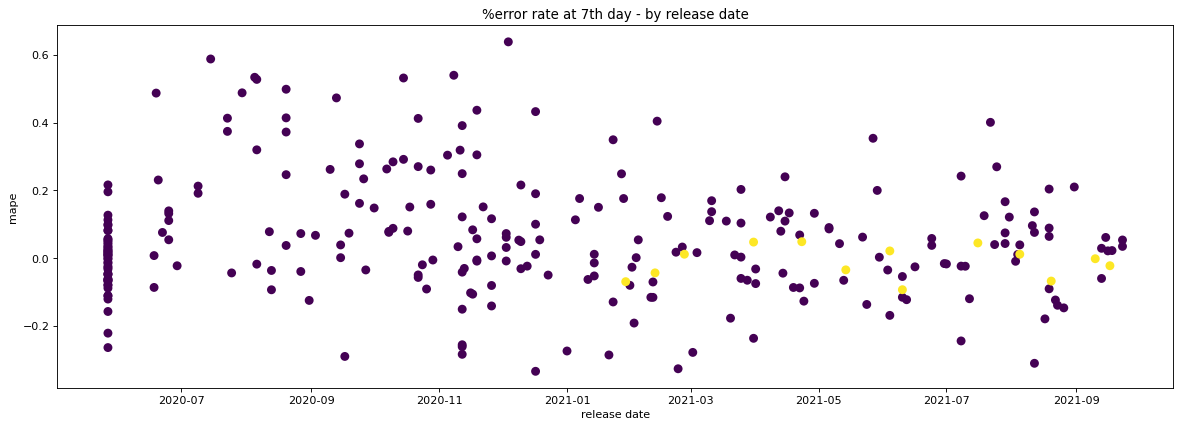

In [165]:
figure(figsize=(18, 6), dpi=80)
plt.scatter(plot_df['available_date'], plot_df['mape'], c = plot_df['color'],
                linewidth=2)
plt.title('%error rate at 7th day - by release date')
plt.xlabel('release date')
plt.ylabel('mape')
# plt.legend()
plt.show()

In [363]:
validation_set[(validation_set['available_date'] >= '2021-03-01')
              &(validation_set['available_date'] <= '2021-05-01')
              &(validation_set['prediction_start_day'] == 7)]\
.groupby(['title', 'available_date','originals_type', 'content_category', 'days_after_launch'])['multiplier'].mean().reset_index()

,title,available_date,originals_type,content_category,days_after_launch,multiplier
0,A Black Lady Sketch Show S2,2021-04-24,originals_after_launch,series,1,NaN
1,A Black Lady Sketch Show S2,2021-04-24,originals_after_launch,series,2,NaN
2,A Black Lady Sketch Show S2,2021-04-24,originals_after_launch,series,3,NaN
3,A Black Lady Sketch Show S2,2021-04-24,originals_after_launch,series,4,NaN
4,A Black Lady Sketch Show S2,2021-04-24,originals_after_launch,series,5,NaN
5,A Black Lady Sketch Show S2,2021-04-24,originals_after_launch,series,6,NaN
6,A Black Lady Sketch Show S2,2021-04-24,originals_after_launch,series,7,1.000000
7,A Black Lady Sketch Show S2,2021-04-24,originals_after_launch,series,8,1.074724
8,A Black Lady Sketch Show S2,2021-04-24,originals_after_launch,series,9,1.115698
9,A Black Lady Sketch Show S2,2021-04-24,originals_after_launch,series,10,1.117496


In [57]:
validation_set['pct_error'] = (validation_set['prediction']-validation_set['actuals'])/validation_set['actuals']

In [58]:
data = validation_set[(validation_set['originals_type'] == 'originals_after_launch') 
                      & (validation_set['content_category'] == 'series') 
                      & (validation_set['days_after_launch'] == 28)
                      & (validation_set['prediction_start_day'] == 5)
                     &(validation_set['pct_error'].notnull())]#['pct_error']

In [71]:
validation_set['abs_pct_error'] = np.abs(validation_set['prediction']-validation_set['actuals'])/validation_set['actuals']
pct_err_df = validation_set.groupby(['originals_type', 'content_category', 'prediction_start_day', 'days_after_launch']).abs_pct_error.mean()
pct_err_df = pd.DataFrame(pct_err_df).reset_index()

In [73]:
pct_err_df.to_csv('Confidence Interval.csv')

In [59]:
def ci_calculation(data, ci_level = 0.95, field = 'pct_error'):
    data = data[data[field].notnull()][field]
    lower, upper = st.t.interval(alpha=ci_level, 
                         df=len(data)-1, 
                         loc=np.mean(data), 
                         scale=st.sem(data)) 
    return lower, upper

In [60]:
ci_calculation(data)

(-0.028802398009749708, 0.05420428502274989)

In [61]:
ci_df = validation_set.groupby(['originals_type', 'content_category', 'prediction_start_day', 'days_after_launch']).apply(ci_calculation)
ci_df = pd.DataFrame(ci_df).reset_index()
ci_df.columns = ['originals_type', 'content_category', 'prediction_start_day', 'days_after_launch', 'pct_error']
ci_df['lower_index'], ci_df['upper_index'] = zip(*ci_df['pct_error'])
ci_df['lower_index'] = ci_df['lower_index'].fillna(0)
ci_df['upper_index'] = ci_df['upper_index'].fillna(0)
ci_df.drop(['pct_error'], axis = 1, inplace = True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [64]:
ci_df.originals_type.unique()

array(['acquired', 'original', 'originals_after_launch', 'popcorn_titles'],
      dtype=object)

In [66]:
ci_df.to_csv('Confidence Interval.csv')

In [469]:
validation_set = pd.merge(validation_set, ci_df, on = ['originals_type', 'content_category', 'prediction_start_day', 'days_after_launch'],
                         how = 'left')
# validation_set['upper_bound'] = validation_set['prediction']/(1+validation_set['lower_index'])
# validation_set['lower_bound'] = validation_set['prediction']/(1+validation_set['upper_index'])
validation_set['upper_bound'] = validation_set['prediction']*validation_set['upper_index']
validation_set['lower_bound'] = validation_set['prediction']*validation_set['lower_index']

In [470]:
plot_df = validation_set[(validation_set['title'] == 'The Undoing S1')
                        &(validation_set['prediction_start_day'] == 7)]

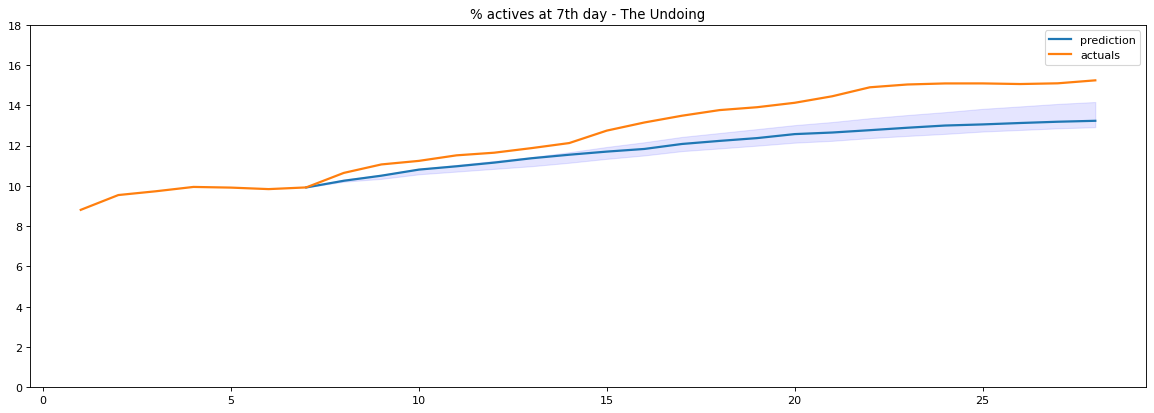

In [471]:
figure(figsize=(18, 6), dpi=80)
plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                linewidth=2, label = 'prediction')
plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                linewidth=2, label = 'actuals')
plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - The Undoing')
plt.ylim(0, 18)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

In [530]:
plot_df = validation_set[(validation_set['title'] == 'Made For Love S1')
                        &(validation_set['prediction_start_day'] == 7)]

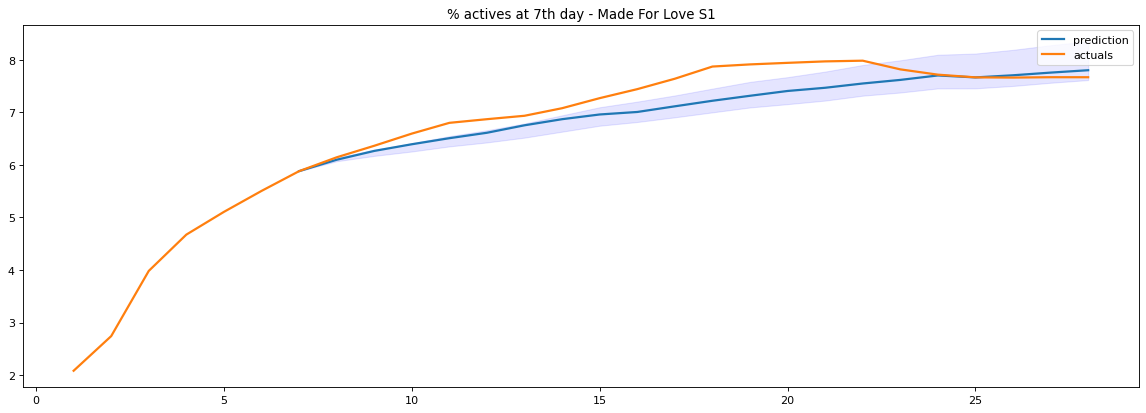

In [531]:
figure(figsize=(18, 6), dpi=80)
plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                linewidth=2, label = 'prediction')
plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                linewidth=2, label = 'actuals')
plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - Made For Love S1')
# plt.ylim(0, 10)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

In [474]:
plot_df = validation_set[(validation_set['title'] == 'Cry Macho')
                        &(validation_set['prediction_start_day'] == 7)]

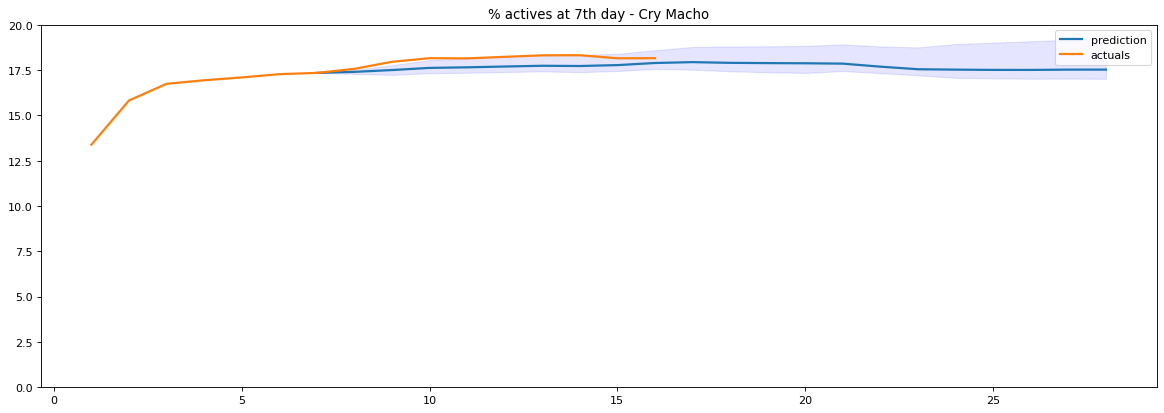

In [475]:
figure(figsize=(18, 6), dpi=80)
plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                linewidth=2, label = 'prediction')
plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                linewidth=2, label = 'actuals')
plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - Cry Macho')
plt.ylim(0, 20)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

In [476]:
# Annual/ Seasonal Effect
# 

In [521]:
plot_df = validation_set[(validation_set['title'] == 'Malignant')
                        &(validation_set['prediction_start_day'] == 7)]

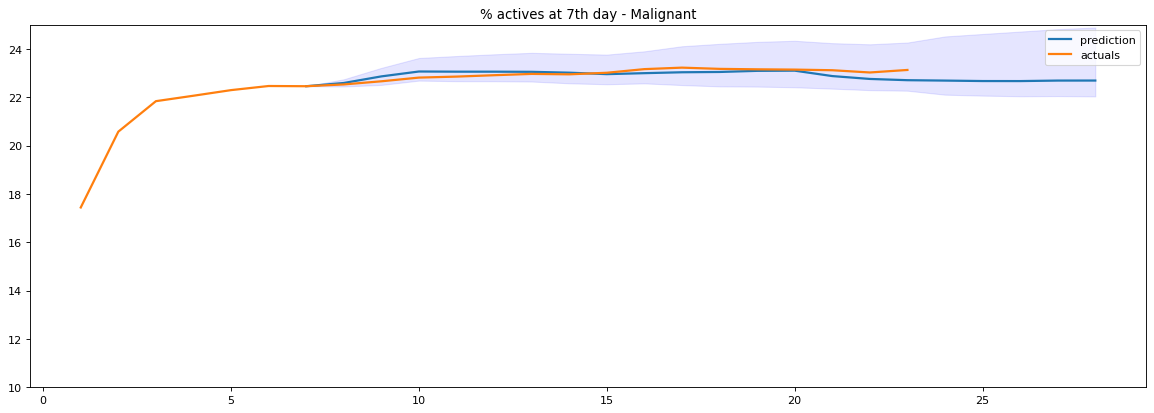

In [522]:
figure(figsize=(18, 6), dpi=80)
plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                linewidth=2, label = 'prediction')
plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                linewidth=2, label = 'actuals')
plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)

plt.title('% actives at 7th day - Malignant')
plt.ylim(10, 25)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

In [519]:
plot_df = validation_set[(validation_set['title'] == 'Cry Macho')
                        &(validation_set['prediction_start_day'] == 7)]

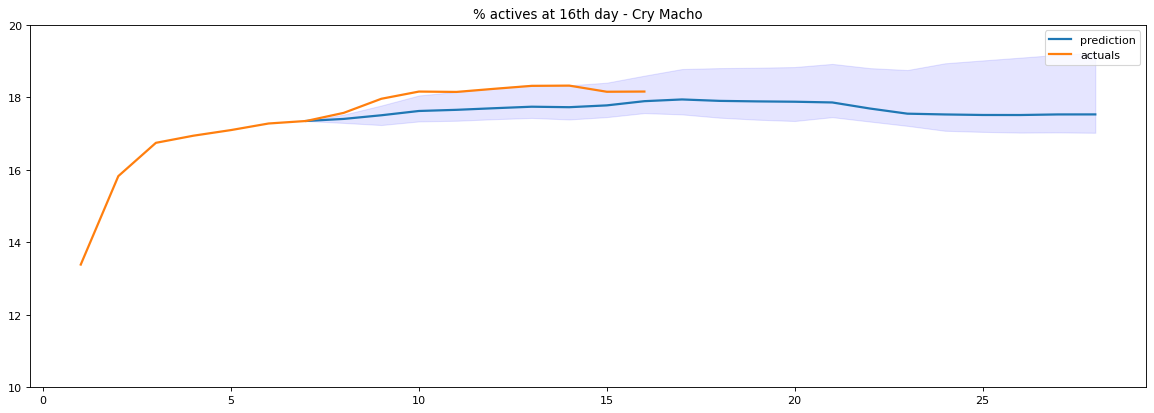

In [520]:
figure(figsize=(18, 6), dpi=80)
plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                linewidth=2, label = 'prediction')
plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                linewidth=2, label = 'actuals')
plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.ylim(10, 20)

plt.title('% actives at 16th day - Cry Macho')
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

In [481]:
plot_df = validation_set[(validation_set['title'] == 'The Many Saints of Newark')
                        &(validation_set['prediction_start_day'] == 2)]

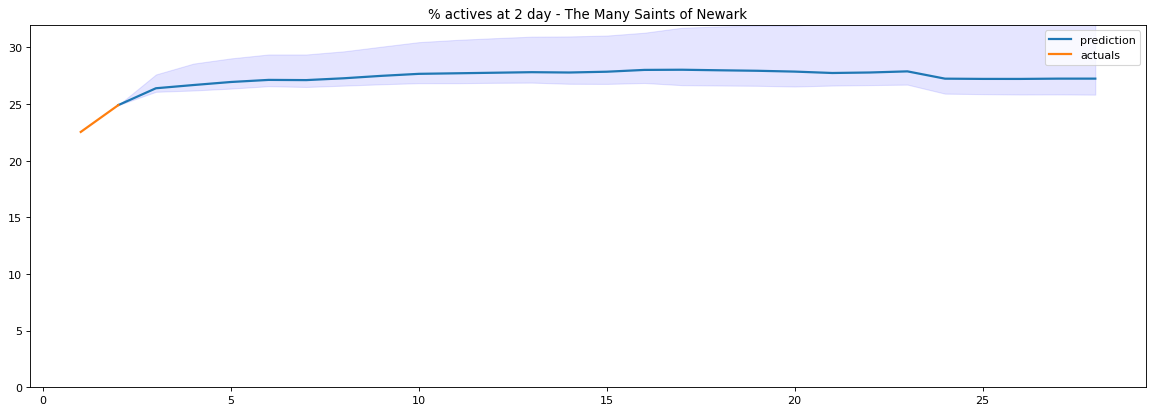

In [483]:
figure(figsize=(18, 6), dpi=80)
plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                linewidth=2, label = 'prediction')
plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                linewidth=2, label = 'actuals')
plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.ylim(0, 32)
plt.title('% actives at 2 day - The Many Saints of Newark')
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

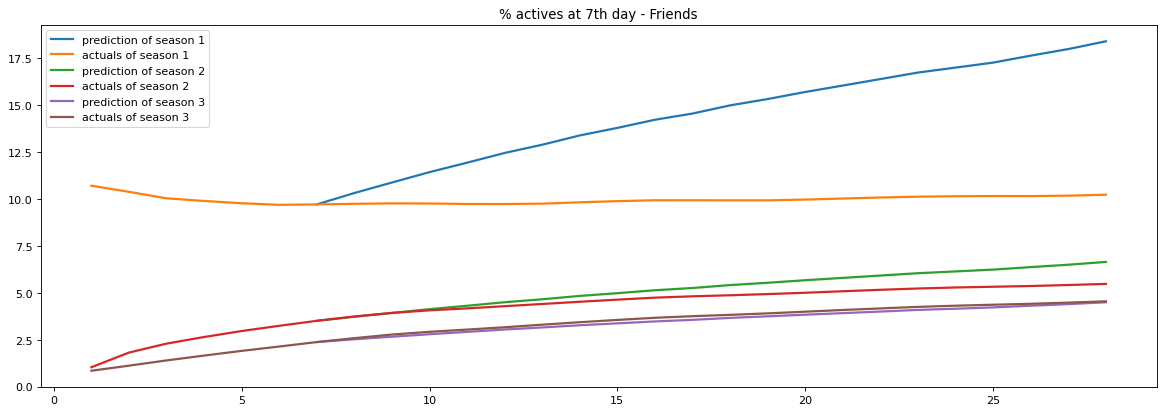

In [118]:
figure(figsize=(18, 6), dpi=80)
for i in range(1, 4, 1):
    plot_df = validation_set[(validation_set['prediction_start_day'] == 7)
                            &(validation_set['title'].str[:-1:1] == 'Friends S')
                            &(validation_set['title'].str[-1::1] == str(i))]\
              .sort_values(by = ['days_after_launch'])
    plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                    linewidth=2, label = 'prediction of season ' + str(i))
    plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                    linewidth=2, label = 'actuals of season ' + str(i))
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - Friends')
# plt.ylim(10, 25)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

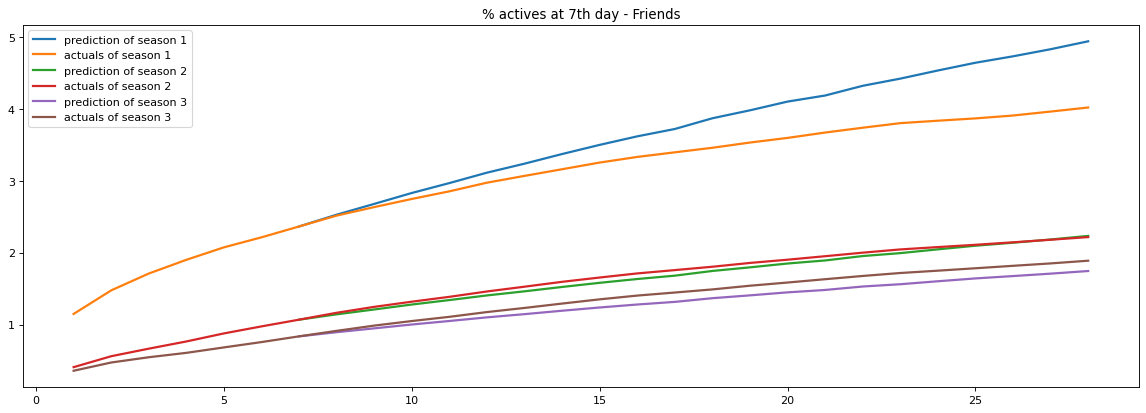

In [124]:
figure(figsize=(18, 6), dpi=80)
for i in range(1, 4, 1):
    plot_df = validation_set[(validation_set['prediction_start_day'] == 7)
                            &(validation_set['title'].str[:-1:1] == 'Game of Thrones S')
                            &(validation_set['title'].str[-1::1] == str(i))]\
              .sort_values(by = ['days_after_launch'])
    plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                    linewidth=2, label = 'prediction of season ' + str(i))
    plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                    linewidth=2, label = 'actuals of season ' + str(i))
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - Friends')
# plt.ylim(10, 25)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

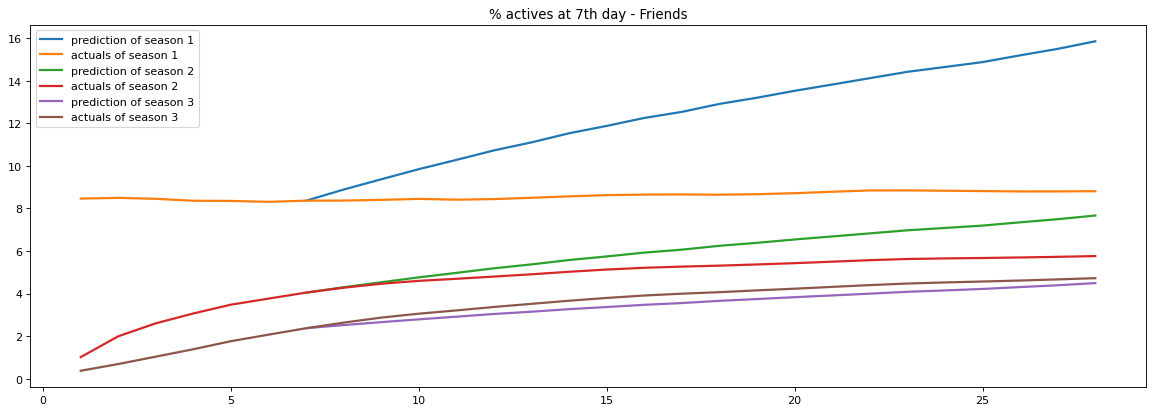

In [126]:
figure(figsize=(18, 6), dpi=80)
for i in range(1, 4, 1):
    plot_df = validation_set[(validation_set['prediction_start_day'] == 7)
                            &(validation_set['title'].str[:-1:1] == 'The Big Bang Theory S')
                            &(validation_set['title'].str[-1::1] == str(i))]\
              .sort_values(by = ['days_after_launch'])
    plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                    linewidth=2, label = 'prediction of season ' + str(i))
    plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                    linewidth=2, label = 'actuals of season ' + str(i))
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - Friends')
# plt.ylim(10, 25)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

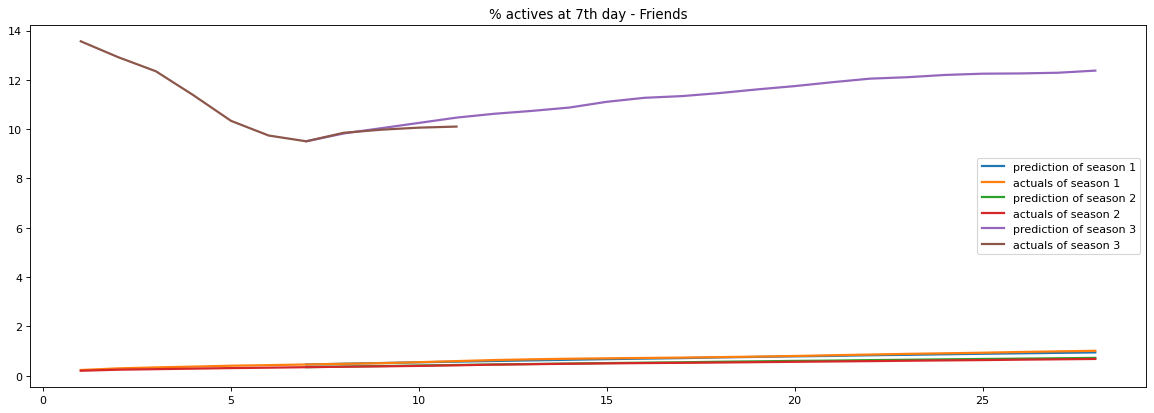

In [127]:
figure(figsize=(18, 6), dpi=80)
for i in range(1, 4, 1):
    plot_df = validation_set[(validation_set['prediction_start_day'] == 7)
                            &(validation_set['title'].str[:-1:1] == 'Succession S')
                            &(validation_set['title'].str[-1::1] == str(i))]\
              .sort_values(by = ['days_after_launch'])
    plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                    linewidth=2, label = 'prediction of season ' + str(i))
    plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                    linewidth=2, label = 'actuals of season ' + str(i))
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - Friends')
# plt.ylim(10, 25)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

# Checks

In [29]:
run_query('''
SELECT *
FROM max_prod.workspace.pct_actives_metric_values_pipeline
where title = 'Love Life S2'
LIMIT 19
''')

,match_id,title,days_on_hbo_max,pct_actives


In [97]:
pct_actives[pct_actives['days_on_hbo_max'] == 28].sort_values(by = ['pct_actives'], ascending = False)\
[['title', 'available_date', 'cumulative_viewing_subs', 'pct_actives']].head(10)

,title,available_date,cumulative_viewing_subs,pct_actives
34204,Wonder Woman 1984,2020-12-25,10748368,69.212320
58383,Godzilla vs. Kong,2021-03-31,14060271,66.939990
93606,Mortal Kombat,2021-04-23,13269788,63.429563
79665,The Suicide Squad,2021-08-05,13074421,58.828669
36086,Zack Snyder's Justice League,2021-03-18,10149794,51.579409
118912,The Little Things,2021-01-29,7898088,50.444608
153922,Space Jam: A New Legacy,2021-07-16,10439444,47.176770
4879,Friends: The Reunion,2021-05-27,8680414,39.245006
44056,Tom & Jerry,2021-02-26,6430998,37.948140
100840,The Conjuring: The Devil Made Me Do It,2021-06-04,8056239,37.831588
